# Transformer Models for Crypto Forecasting

The purpose of this project is to investigate whether transformers can accurately forecast minute-level cryptocurrency prices. We do this by building a decoder-only transformer with convolutional self-attention and training it on past BTC, ETH, ADA, and SOL prices. Our approach is ultimately not successful, and in the final section we discuss some ideas for improving performance. 

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn 
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
import math
from tqdm import tqdm
import pandas
import numpy as np
import random

# random seeds
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)


# this will be server specific
device = 'cuda:5'

/home/lily/zaa7/miniconda3/envs/pyt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.__version__)

1.11.0


## The Model

### Causal Convolution Layer
The only way our transformer architecture differs from a standard GPT-style decoder is the use of *convolutional self-attention*, a method introduced in [Li et al](https://arxiv.org/abs/1907.00235). 

In language modelling, where our input is a sequence of discrete tokens, we create input embeddings by training a look-up table that maps tokens to embeddings. However, in financial time-series modelling, this approach doesn't work because our data is continuous. 

The proposal of Li et al. is to use *causal convolutions* to construct input embeddings. A causal convolution is a 1D convolution, except the sliding window extends only backwards in time, which is a necessary constraint for dealing with time-series data. We turn our *(seqlen)* input sequence into a *(seqlen, num_features)* sequence of input embeddings by stacking the result of *num_features* causal convolutions on the input sequence. 

In [3]:
class CausalConv1d(torch.nn.Conv1d):
    def __init__(self,
                 embed_dim,
                 kernel_size,
                 bias=True):

        super(CausalConv1d, self).__init__(
            in_channels=1,
            out_channels=embed_dim,
            kernel_size=kernel_size,
            stride=1,
            padding=0,
            dilation=1,
            groups=1,
            bias=bias)
        
        self.__padding = kernel_size - 1
    
    """
    - Output has indices [batch, seqlen, features]
    """
    def forward(self, input):
        padded = F.pad(input.unsqueeze(1), (self.__padding, 0))
        return torch.tanh(super(CausalConv1d, self).forward(padded)).permute(0, 2, 1)

### The Transformer

Apart from the causal convolution layer, our transformer is a standard decoder-only architecture. For an input of shape *(seqlen)*, the decoder outputs a vector of shape *(seqlen)* where the *i*th index corresponds to a prediction for the price at time *i+1*. 

We use greedy decoding for sequence generation. This is quite risky, as greedy decoding is prone to cascading errors (if you generate an incorrect price, your next prediction is conditioned on an incorrect price, leading to an even worse prediction for the next price). It is possible greedy decoding is a major culprit for our poor performance. 

In [5]:
class TimeFormer(torch.nn.Module): 
    def __init__(self, 
                 d_in, 
                 d_model, 
                 max_seqlen,
                 num_heads, 
                 dropout=0.1): 
        super(TimeFormer, self).__init__()
        
        self.d_in = d_in
        self.num_heads = num_heads
        
        self.conv_embed = CausalConv1d(embed_dim=d_in, kernel_size=9)
        self.positional_embed = nn.Embedding(max_seqlen, d_in)
        
        encoder_layer = nn.TransformerEncoderLayer(d_in, 
                                                        nhead=num_heads, 
                                                        dim_feedforward=d_model, 
                                                        activation='gelu', 
                                                        batch_first=True
                                                       )
        norm1 = nn.LayerNorm(d_in)
        self.decoder = nn.TransformerEncoder(encoder_layer, num_layers=2, norm=norm1)
                
        self.dense = nn.Linear(d_in, 1)
        
        
        
    """
    - x has indices [batch, seqlen]
    """
    def forward(self, x): 
        batch_size, seqlen = x.size()
        
        mask = torch.tril(torch.ones((seqlen, seqlen), device=x.device), 
                          diagonal=1)
        
        conv_embedding = self.conv_embed(x)
        pos_embedding = self.positional_embed(torch.arange(seqlen, 
                                                          device=x.device))
        
        input_embedding = conv_embedding + pos_embedding 
        
        attn_out = self.decoder(input_embedding, mask)
                
        outputs = self.dense(attn_out)
        
        return torch.squeeze(outputs, dim=2)
    
    """
    Greedy decoding
    
    - x has indices [batch, seqlen]
    """
    def batch_generate(self, x, new_time_steps):         
        seq = x 
        
        for _ in range(new_time_steps): 
            outs = self.forward(seq)
            
            seq = torch.cat((seq, outs[:, -1:]), dim=1)
        
        return seq 
            
            

## Making sure there are no bugs...
Testing a few forward passes on randomly generated data to make sure the input/output shapes are what we think they are. 

In [6]:
ins = torch.rand((3, 10))

model = TimeFormer(d_in = 16, 
                   d_model = 32, 
                   max_seqlen = 256, 
                   num_heads = 4, 
                  )

out = model.forward(ins)
print("out shape: ", out.shape)
print(out)

out shape:  torch.Size([3, 10])
tensor([[ 0.1984, -1.1482,  0.5940,  0.1100, -0.3594, -0.5084, -0.4710,  0.8415,
         -0.4105, -0.2544],
        [ 0.3458, -1.0379,  0.4630,  0.2185, -0.8721, -0.4912, -0.7056,  0.9604,
         -0.3102, -0.0662],
        [ 0.0504, -1.2186,  0.6059,  0.0539, -0.4676, -0.2291, -0.9166,  0.7973,
         -0.4858, -0.3148]], grad_fn=<SqueezeBackward1>)


In [7]:
model = TimeFormer(d_in = 16, 
                   d_model = 32, 
                   max_seqlen = 256, 
                   num_heads = 4, 
                  )
ins = torch.rand((3, 10))

model.batch_generate(ins, 5)

tensor([[ 0.6381,  0.6077,  0.1084,  0.2612,  0.0944,  0.5486,  0.5978,  0.7587,
          0.7899,  0.1105, -0.9278, -0.0771, -0.1093, -1.0772, -0.2915],
        [ 0.1330,  0.5507,  0.6662,  0.8219,  0.7729,  0.0344,  0.5591,  0.6124,
          0.9848,  0.1965, -0.9884, -0.2815, -0.3824, -1.2690, -0.6631],
        [ 0.0446,  0.7101,  0.0092,  0.8133,  0.9771,  0.3943,  0.7602,  0.5465,
          0.2308,  0.8350, -0.9661, -0.3167, -0.1398, -1.2992, -0.7725]],
       grad_fn=<CatBackward0>)

## Data Preprocessing

# Training on synthetic data
To make sure there are no bugs in our code, we'll train our TimeFormer model on a very simple synthetic dataset consisting of two sine waves. 

In [9]:
sinewave = torch.sin(torch.linspace(0, 8*math.pi, 256))
sinewave1 = torch.cos(torch.linspace(2, 5, 256))

tnsr = torch.stack((sinewave, sinewave1))
miniset = TensorDataset(tnsr)

We use the AdamW optimizer and a straightforward MSE loss. 

In [10]:
minimodel = TimeFormer(d_in = 64, 
                   d_model = 256, 
                   max_seqlen = 256, 
                   num_heads = 4, 
                  ).to(device)

#"3e-4 is the best learning rate for Adam, hands down" - Andrej Karpathy 
lr = 3e-4
optimizer = AdamW(minimodel.parameters(), lr=lr)

loss_fn = nn.MSELoss()

100%|███████████████████████████████████████████████| 10000/10000 [01:57<00:00, 85.07it/s]


Text(0, 0.5, 'log loss')

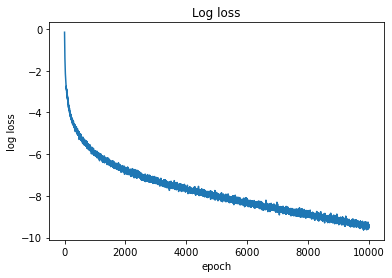

In [11]:
num_epochs = 10000

miniloader = DataLoader(miniset, batch_size=2)

log_losses = []
for i in tqdm(range(num_epochs)): 
    for _, batch in enumerate(miniloader):
        optimizer.zero_grad()
        
        batch = batch[0].to(device)
        outs = minimodel.forward(batch)
        
        target = batch[:, 1:]
        predictions = outs[:, :-1]
        
        loss = loss_fn(target, predictions)
        
        loss.backward()
        optimizer.step()
        log_losses.append(math.log(loss.item()))
        
plt.plot(log_losses)
plt.title("Log loss")
plt.xlabel("epoch")
plt.ylabel("log loss")

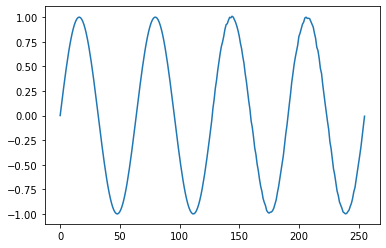

In [12]:
test = sinewave[:128].unsqueeze(dim=0).to(device)

with torch.no_grad(): 
    completion = minimodel.batch_generate(test, 128)

plt.plot(completion[0].cpu())
plt.show()

You almost can't tell when the input sequence ends! So we know our implementation isn't *completely* a buggy mess. 

## Cryptoarchive Dataset

We pull BTC, ETH, ADA, and BTC minute-frequency prices from [cryptoarchive](https://www.cryptoarchive.com.au/dashboard). We split the stream of prices into chunks of 1024 minutes, since that is the longest input our model handles. 

In [13]:
MAX_SEQLEN = 1024

In [14]:
names = ["open time stamp", "open", "high", "low", "close", "volume", 
        "taker buy quote asset volume", "taker buy base asset volume", 
        "quote asset volume", "number of trades"]

sol_dataframe = pandas.read_csv("SOLUSDC.csv", sep="|", names=names)
eth_dataframe = pandas.read_csv("ETHUSDC.csv", sep="|", names=names)
ada_dataframe = pandas.read_csv("ADAUSDC.csv", sep="|", names=names)
btc_dataframe = pandas.read_csv("BTCUSDC.csv", sep="|", names=names)

In [15]:
sol_dataframe

,open time stamp,open,high,low,close,volume,taker buy quote asset volume,taker buy base asset volume,quote asset volume,number of trades
0,1632477600,147.12,147.12,135.99,135.99,1.35,185.99,1.35,185.99,4
1,1632477660,135.70,136.00,128.34,128.34,78.55,10486.50,77.54,10616.12,10
2,1632477720,136.37,136.37,136.37,136.37,1.16,158.19,1.16,158.19,1
3,1632477780,134.87,136.35,134.87,136.35,3.30,81.81,0.60,446.78,3
4,1632477840,136.29,136.61,136.23,136.61,9.79,1200.75,8.79,1336.98,5
...,...,...,...,...,...,...,...,...,...,...
251500,1647574800,85.90,85.90,85.90,85.90,0.00,0.00,0.00,0.00,0
251501,1647574860,85.90,85.90,85.90,85.90,0.00,0.00,0.00,0.00,0
251502,1647574920,85.88,85.88,85.88,85.88,0.23,0.00,0.00,19.75,1
251503,1647574980,85.76,85.76,85.71,85.73,3.10,0.00,0.00,265.77,4


In [16]:
def df_to_numpy(df, max_seqlen): 
    prices_series = df.loc[:, "open"]
    prices_vec = prices_series.to_numpy()
    prices_vec = prices_vec[:-(prices_vec.size%max_seqlen)]
    norm_factor = np.max(prices_vec)
    prices_vec = prices_vec/norm_factor
    prices_mat = prices_vec.reshape((-1, max_seqlen))
    return torch.tensor(prices_mat)

In [17]:

sol_mat = df_to_numpy(sol_dataframe, MAX_SEQLEN)
eth_mat = df_to_numpy(eth_dataframe, MAX_SEQLEN)
ada_mat = df_to_numpy(ada_dataframe, MAX_SEQLEN)
btc_mat = df_to_numpy(btc_dataframe, MAX_SEQLEN)


all_mat = np.concatenate((sol_mat, eth_mat, ada_mat, btc_mat))

np.random.shuffle(all_mat)

print(all_mat.shape)

(5103, 1024)


In [18]:
# hold out 500 examples for the test set
test_tensor = torch.tensor(all_mat[-500:], dtype=torch.float)

trainset = TensorDataset(torch.tensor(all_mat[:-500], dtype=torch.float))
testset = TensorDataset(test_tensor)

# Training on Crypto Data

Our training loop is completely standard, no innovation here. We use an MSE loss and train more or less to convergence. 

In [19]:
model = TimeFormer(d_in = 1024, 
                   d_model = 4096, 
                   max_seqlen = MAX_SEQLEN, 
                   num_heads = 8, 
                  ).to(device)

#"3e-4 is the best learning rate for Adam, hands down" - Andrej Karpathy 
lr = 5e-5
optimizer = AdamW(model.parameters(), lr=lr)

loss_fn = nn.MSELoss()

100%|███████████████████████████████████████████████████| 144/144 [00:37<00:00,  3.79it/s]


epoch 0: loss 0.032079923897981644


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 1: loss 0.004138257820159197


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 2: loss 0.0033761372324079275


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 3: loss 0.0026942617259919643


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 4: loss 0.0020693165715783834


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 5: loss 0.0014920505927875638


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 6: loss 0.00104802125133574


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 7: loss 0.000782915682066232


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 8: loss 0.0006194872548803687


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 9: loss 0.0005179767613299191


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 10: loss 0.00045061009586788714


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 11: loss 0.0003980040783062577


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 12: loss 0.0003666318953037262


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 13: loss 0.0003360552655067295


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 14: loss 0.0003141909255646169


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 15: loss 0.0002876647049561143


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 16: loss 0.0002686351945158094


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 17: loss 0.0002550377685111016


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 18: loss 0.00024624858633615077


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 19: loss 0.0002321596839465201


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 20: loss 0.0002302915818290785


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 21: loss 0.00022521454957313836


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 22: loss 0.00021796785586047918


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 23: loss 0.00021320626547094434


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 24: loss 0.00020219883299432695


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 25: loss 0.00019849310046993196


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 26: loss 0.0002006009017350152


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 27: loss 0.00019632578187156469


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 28: loss 0.0001815890718717128


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 29: loss 0.0001905047829495743


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 30: loss 0.00017374835442751646


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 31: loss 0.00017884594853967428


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 32: loss 0.0001798456214601174


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 33: loss 0.00018905125034507364


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 34: loss 0.0001611597981536761


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 35: loss 0.00016518047777935863


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 36: loss 0.00016389178927056491


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 37: loss 0.0001686664909357205


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 38: loss 0.0001589321909705177


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 39: loss 0.0002114276576321572


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 40: loss 0.00016800739103928208


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 41: loss 0.00013174251944292337


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 42: loss 0.00013391680840868503


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 43: loss 0.00014802977966610342


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 44: loss 0.00016059682820923626


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 45: loss 0.0001520160585641861


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 46: loss 0.00013447819219436496


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 47: loss 0.00016448658425360918


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 48: loss 0.00018115638522431254


100%|███████████████████████████████████████████████████| 144/144 [00:38<00:00,  3.77it/s]


epoch 49: loss 0.00013481864880304784


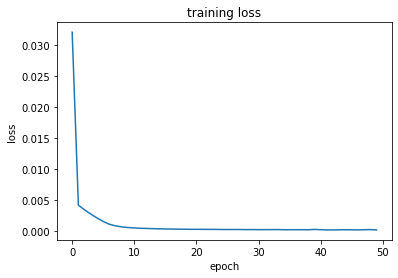

In [20]:
num_epochs = 50

train_loader = DataLoader(trainset, batch_size=32)

losses = []
for i in range(num_epochs): 
    cum_loss = 0 
    num_batches = 0 
    for _, batch in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        
        batch = batch[0].to(device)
        outs = model.forward(batch)
        
        target = batch[:, 1:]
        predictions = outs[:, :-1]
        
        loss = loss_fn(target, predictions)
        
        loss.backward()
        optimizer.step()
        
        cum_loss += loss
        num_batches += 1 
    
    total_loss = (cum_loss / num_batches).cpu().item()
    losses.append(total_loss)
    
    print(f"epoch {i}: loss {total_loss}")
        
plt.plot(losses)
plt.title("training loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# save model state_dict
torch.save(model.state_dict(), "saved_weights.pth")

# Evaluation

In [21]:
# Loads saved weights
device = 'cuda:7'

model = TimeFormer(d_in = 1024, 
                   d_model = 4096, 
                   max_seqlen = MAX_SEQLEN, 
                   num_heads = 8, 
                  ).to(device)

model.load_state_dict(torch.load("saved_weights.pth"))

<All keys matched successfully>

We will evaluate the our model on the following task: given the past 512 minutes of prices, predict the next 512 minutes of prices. Our accuracy metric is MSE.

## Baseline accuracy
I never check the weather report. Instead, I wear what would've been appropriate attire for the previous day's weather. This works ok maybe 95% of the time. To establish a reasonable baseline our transformer should beat we follow a similar logic. 

In [22]:
# Calculate accuracy of "just predict the last price" model. 

mse = nn.MSELoss()
accuracy = mse(test_tensor[:, -2], test_tensor[:, -1])

print(f"The MSE to beat is {accuracy}")

The MSE to beat is 1.8912913901658612e-07


In [25]:
minutes_to_predict = 512

In [36]:
# Calculate accuracy of "just predict the last price" model. 

mse = nn.MSELoss()
predictions = test_tensor[:, -(minutes_to_predict+1)].unsqueeze(dim=1).repeat(1, minutes_to_predict)
targets = test_tensor[:, -minutes_to_predict:]
accuracy = mse(predictions, targets)

print(f"The MSE to beat is {accuracy}")

The MSE to beat is 5.840558515046723e-05


## Model Accuracy

In [37]:
test_loader = DataLoader(testset, batch_size=50)

model.eval()

MSEs = []
for _, batch in enumerate(tqdm(test_loader)): 
    batch = batch[0].to(device)
    
    inputs = batch[:, -minutes_to_predict:]
    with torch.no_grad():
        outs = model.batch_generate(inputs, minutes_to_predict)
    
    error = mse(batch[:, -minutes_to_predict], outs[:, -minutes_to_predict])
    MSEs.append(error.cpu().item())

accuracy = sum(MSEs)/len(MSEs)


print(f"the model accuracy is {accuracy}")

100%|█████████████████████████████████████████████████████| 10/10 [09:08<00:00, 54.85s/it]

the model accuracy is 0.0002232983402791433


# Post-mortem

In the end, we see that our transformer-based approach does not beat simply predicting the most recent known price. Below I discuss a number of reasons for why this may be the case. 
- It may be that our data doesn't contain any signal, in the sense that there is no better model of our data than a random walk. If this is the case, one solution is to include as the input to our model covariate time series such as the prices of other assets or market metadata. It could be that past prices alone carry no signal about future prices, but past prices combined with covariates do. 
- It may be that while our transformer model succeeds at building rich representations, regressing a point estimate for future price and using greedy decoding to predict sequences is too crude of a decoding approach. We mentioned earlier the problem of cascading errors. We might improve our model by outputting a probabilitiy distribution over prices instead of a point estimate and using beam search to generate sequences. This would allow us to draw diverse samples from the transformer model as we can with text generation models. 
- Transformers have weak inductive biases and are notoriously data hungry. It may be that we simply didn't train our model on enough data. In fact, the fact that our transformer model performs *worse* than our baseline. suggests this is the most likely explanation. If there were genuinely no signal in our data but we had enough of it, our model would learn to always predict the empirical mean---greedy decoding and deterministic outputs wouldn't prevent this behavior.   